In [2]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 7.5 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
!gdown 1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q

Downloading...
From: https://drive.google.com/uc?id=1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q
To: /content/dataset.zip
100% 230k/230k [00:00<00:00, 3.95MB/s]


In [5]:
!unzip /content/dataset.zip -d /content

Archive:  /content/dataset.zip
   creating: /content/dataset/
  inflating: /content/dataset/all-data.csv  


In [6]:
dataset_path = 'dataset/all-data.csv'
headers = ['sentiment', 'content']
df = pd.read_csv(
    dataset_path,
    names=headers,
    encoding='ISO-8859-1'
)

In [7]:
classes = {
    class_name: idx for idx, class_name in enumerate(df['sentiment'].unique().tolist())
}
df['sentiment'] = df['sentiment'].apply(
    lambda sentiment: classes[sentiment]
)

In [8]:
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
    text = text.lower()
    text = unidecode.unidecode(text)
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split(' ')])

    return text

In [9]:
df['content'] = df['content'].apply(
    lambda content: text_normalize(content)
)

In [10]:
vocab = []

for sentence in df['content'].tolist():
    tokens = sentence.split()
    for token in tokens:
        if token not in vocab:
            vocab.append(token)

vocab.append('UNK')
vocab.append('PAD')
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

In [11]:
def transform(text, word_to_idx, max_seq_len):
    tokens = []
    for w in text.split():
        try:
            w_ids = word_to_idx[w]
        except:
            w_ids = word_to_idx['UNK']
        tokens.append(w_ids)

    if len(tokens) < max_seq_len:
        tokens += [word_to_idx['PAD']] * (max_seq_len - len(tokens))
    elif len(tokens) > max_seq_len:
        tokens = tokens[:max_seq_len]

    return tokens

In [12]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts,
    labels,
    test_size=val_size,
    shuffle=is_shuffle,
    random_state=seed
)

X_train, X_test, y_train, y_test = train_test_split(
    texts,
    labels,
    test_size=test_size,
    shuffle=is_shuffle,
    random_state=seed
)

In [13]:
class FinancialNews(Dataset):
    def __init__(self, X, y, word_to_idx, max_seq_len, transform=None):
        self.texts = X
        self.labels = y
        self.word_to_idx = word_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        if self.transform:
            text = self.transform(
                text,
                self.word_to_idx,
                self.max_seq_len
            )
        text = torch.tensor(text)

        return text, label

In [14]:
max_seq_len = 32

train_dataset = FinancialNews(
    X_train, y_train,
    word_to_idx = word_to_idx,
    max_seq_len = max_seq_len,
    transform=transform
)

val_dataset = FinancialNews(
    X_val, y_val,
    word_to_idx = word_to_idx,
    max_seq_len = max_seq_len,
    transform=transform
)

test_dataset = FinancialNews(
    X_test, y_test,
    word_to_idx = word_to_idx,
    max_seq_len = max_seq_len,
    transform=transform
)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)

In [15]:
class SentimentClassifier(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim,
        hidden_size, n_layers, n_classes, dropout_prob):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(
            embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [16]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentimentClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=dropout_prob
).to(device)

lr = 1e-4
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [21]:
def fit(
    model, train_loader, val_loader,
    criterion, optimizer, device, epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []
        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = np.mean(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader, criterion, device
        )
        val_losses.append(val_loss)
        print(f'EPOCH {epoch + 1}: Train loss {train_loss:.4f} Val loss: {val_loss:.4f}')

    return train_losses, val_losses

def evaluate(model, dataloader, criterion, device, ):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = np.mean(losses)
    val_acc = correct / total

    return val_loss, val_acc

In [22]:
train_losses, val_losses = fit(
    model, train_loader, val_loader,
    criterion, optimizer, device, epochs
)

EPOCH 1: Train loss 0.7975 Val loss: 0.8521
EPOCH 2: Train loss 0.8034 Val loss: 0.8549
EPOCH 3: Train loss 0.8147 Val loss: 0.8531
EPOCH 4: Train loss 0.7943 Val loss: 0.8455
EPOCH 5: Train loss 0.7851 Val loss: 0.8486
EPOCH 6: Train loss 0.7809 Val loss: 0.8509
EPOCH 7: Train loss 0.7818 Val loss: 0.8432
EPOCH 8: Train loss 0.7741 Val loss: 0.8615
EPOCH 9: Train loss 0.7778 Val loss: 0.8408
EPOCH 10: Train loss 0.7637 Val loss: 0.8387
EPOCH 11: Train loss 0.7782 Val loss: 0.8361
EPOCH 12: Train loss 0.7781 Val loss: 0.8372
EPOCH 13: Train loss 0.7612 Val loss: 0.8383
EPOCH 14: Train loss 0.7658 Val loss: 0.8873
EPOCH 15: Train loss 0.7503 Val loss: 0.8359
EPOCH 16: Train loss 0.7603 Val loss: 0.8433
EPOCH 17: Train loss 0.7634 Val loss: 0.8421
EPOCH 18: Train loss 0.7510 Val loss: 0.8309
EPOCH 19: Train loss 0.7470 Val loss: 0.8359
EPOCH 20: Train loss 0.7602 Val loss: 0.8453
EPOCH 21: Train loss 0.7358 Val loss: 0.8327
EPOCH 22: Train loss 0.7416 Val loss: 0.8410
EPOCH 23: Train los

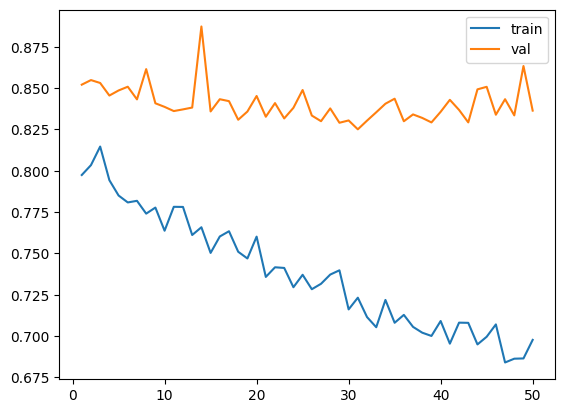

In [24]:
import matplotlib.pyplot as plt

# Assuming 'epochs' is an integer (e.g., 50)
epoch_range = range(1, epochs + 1)  # Create a range of values for the x-axis

plt.plot(epoch_range, train_losses, label='train')
plt.plot(epoch_range, val_losses, label='val')
plt.legend()
plt.show()

In [25]:
val_loss, val_acc = evaluate(
    model, val_loader, criterion, device
)
print(f'Val loss: {val_loss:.4f}')

test_loss, test_acc = evaluate(
    model, test_loader, criterion, device
)
print(f'Test loss: {test_loss:.4f}')

print('Evaluation on val/test dataset')
print('Val accuracy:', val_acc )
print('Test accuracy:', test_acc)

Val loss: 0.8364
Test loss: 0.9151
Evaluation on val/test dataset
Val accuracy: 0.668041237113402
Test accuracy: 0.6171617161716172


### LSTM

In [28]:
class SentimentClassifierLSTM(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim,
        hidden_size, n_layers, n_classes, dropout_prob):
        super(SentimentClassifierLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(
            embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [30]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

modelLSTM = SentimentClassifierLSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=dropout_prob
).to(device)

lr = 1e-4
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelLSTM.parameters(), lr=lr)

In [31]:
train_losses, val_losses = fit(
    modelLSTM, train_loader, val_loader,
    criterion, optimizer, device, epochs
)

EPOCH 1: Train loss 1.0178 Val loss: 0.9298
EPOCH 2: Train loss 0.9323 Val loss: 0.9277
EPOCH 3: Train loss 0.9260 Val loss: 0.9272
EPOCH 4: Train loss 0.9240 Val loss: 0.9271
EPOCH 5: Train loss 0.9236 Val loss: 0.9261
EPOCH 6: Train loss 0.9348 Val loss: 0.9278
EPOCH 7: Train loss 0.9260 Val loss: 0.9266
EPOCH 8: Train loss 0.9318 Val loss: 0.9258
EPOCH 9: Train loss 0.9210 Val loss: 0.9258
EPOCH 10: Train loss 0.9238 Val loss: 0.9256
EPOCH 11: Train loss 0.9238 Val loss: 0.9254
EPOCH 12: Train loss 0.9237 Val loss: 0.9244
EPOCH 13: Train loss 0.9270 Val loss: 0.9246
EPOCH 14: Train loss 0.9238 Val loss: 0.9242
EPOCH 15: Train loss 0.9225 Val loss: 0.9217
EPOCH 16: Train loss 0.9167 Val loss: 0.9203
EPOCH 17: Train loss 0.9134 Val loss: 0.9122
EPOCH 18: Train loss 0.8901 Val loss: 0.9094
EPOCH 19: Train loss 0.8978 Val loss: 0.8987
EPOCH 20: Train loss 0.8943 Val loss: 0.8954
EPOCH 21: Train loss 0.8724 Val loss: 0.8926
EPOCH 22: Train loss 0.8665 Val loss: 0.8827
EPOCH 23: Train los

In [34]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'financial_model_weights.pt')